# Diamond price prediction 

Build a linear model that predicts the prices of diamonds based on their attributes

In [1]:
#load the necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/diamond-dataset/diamonds.csv


In [2]:
#load the data

df = pd.read_csv('/kaggle/input/diamond-dataset/diamonds.csv')
df

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


## Data Cleaning and validation 
* Check for missing values
* Reaname columns into more meaningful names
* Drop redundant or unnecessary columns 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [4]:
# check for missing values 
df.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

The dataset have 53,940 observations and 11 features, with no missing values

In [5]:
#drop duplicate values
df.drop_duplicates(inplace = True)

In [6]:
#drop the unnamed column
df.drop('Unnamed: 0', axis = 1, inplace = True)

#rename columns into a more meaningful names
colnames = {'x': 'length', 
           'y': 'width',
           'z': 'depth',
           'depth': 'total_depth'}
df.rename(columns = colnames, inplace = True)
df

,carat,cut,color,clarity,total_depth,table,price,length,width,depth
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


## Exploratory analysis

In [7]:
# Summary statistic of the data
df.describe()

,carat,total_depth,table,price,length,width,depth
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


,count
cut,
Ideal,21551
Premium,13791
Very Good,12082
Good,4906
Fair,1610


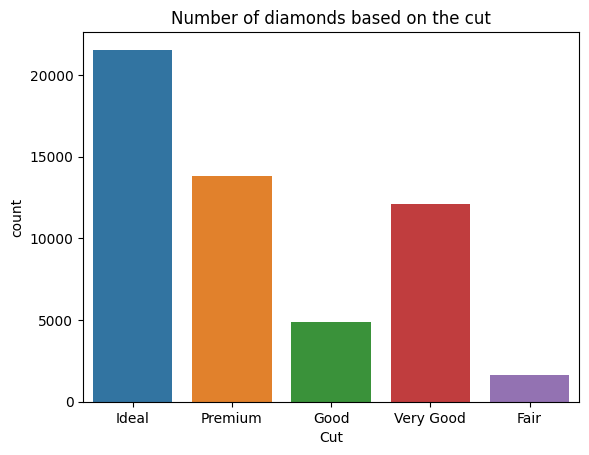

In [8]:
display(pd.DataFrame(df['cut'].value_counts()))

sns.countplot(x = df['cut'])
plt.title('Number of diamonds based on the cut')
plt.xlabel('Cut')
plt.show()

From the table and visualization above, the dataset have more diamonds of Ideal cut, with 21,551 observations being ideal, followed by Premium and Very good, with Fair cut being the category with the least amount of diamonds.

,price
cut,
Fair,4358.757764
Good,3928.864452
Ideal,3457.541970
Premium,4584.257704
Very Good,3981.759891


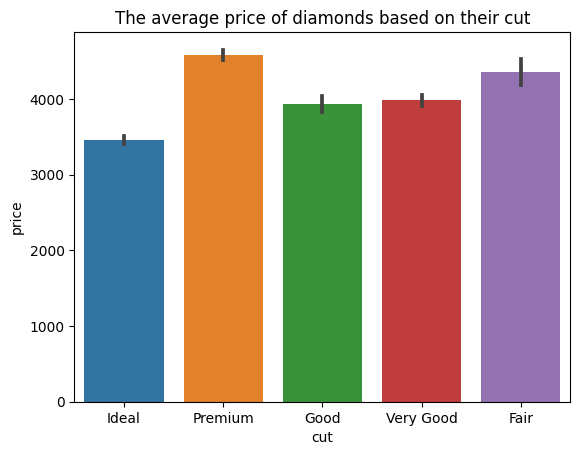

In [9]:
display(pd.DataFrame(df.groupby('cut')['price'].mean()))

# The average price of diamonds based on their cut
sns.barplot(x = df['cut'], y = df['price'])
plt.title('The average price of diamonds based on their cut')
plt.show()

There is significant difference in the average price of diamonds based on their cut, with ideal having the least average price which is counter intuitive as you would normally expect diamonds with an ideal cut to cost averagely more than diamonds with fair cut.

To confirm there's a statiscally significant difference between the average prices of the categories as the graph suggested, I performed an Anova test on the groups 

In [10]:
# To confirm if there's significant difference in the mean price of diamonds based on cut

ideal_cut = np.array(df[df['cut'] == 'Ideal']['price'])
premium_cut = np.array(df[df['cut'] == 'Premium']['price'])
good_cut = np.array(df[df['cut'] == 'Good']['price'])
very_good_cut = np.array(df[df['cut'] == 'Very Good']['price'])
fair_cut = np.array(df[df['cut'] == 'Fair']['price'])

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(ideal_cut, premium_cut, good_cut, very_good_cut, fair_cut)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# With p-value of 8.43e-150, we can reject the null hypothesis and infer there's significant difference in the 
# mean price of diamonds across the cuts 

F-statistic: 175.68871735080606
p-value: 8.42830730759452e-150


With p-value of 8.43e-150, we can reject the null hypothesis and infer there's significant difference in the mean price of diamonds across the cuts.

,count
clarity,
SI1,13065
VS2,12258
SI2,9194
VS1,8171
VVS2,5066
VVS1,3655
IF,1790
I1,741


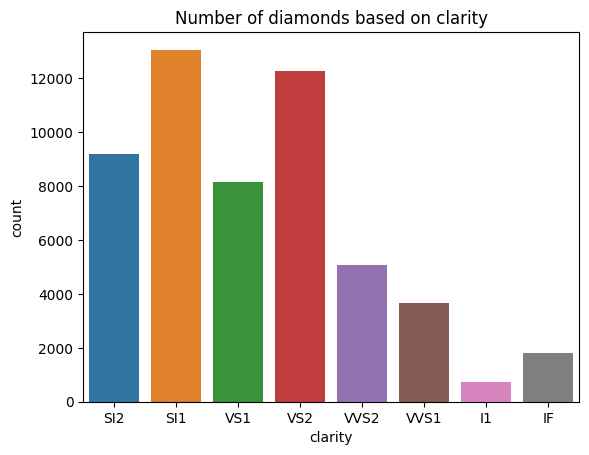

In [11]:
# count of daimonds based on their clarity
display(pd.DataFrame(df['clarity'].value_counts()))

sns.countplot(x = df['clarity'])
plt.title('Number of diamonds based on clarity')
plt.show()

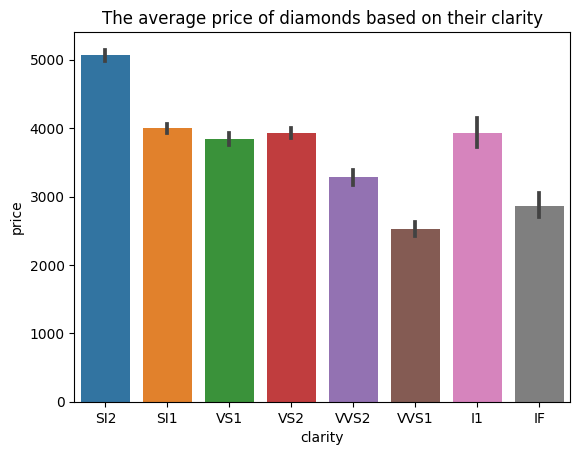

In [12]:
sns.barplot(x = df['clarity'], y = df['price'])
plt.title('The average price of diamonds based on their clarity')
plt.show()

The visualizations above shows that category SI1 have the highest number of diamonds in the dataset, and on average category SI2 have the most expensive diamonds.

,count
clarity,
SI1,13065
VS2,12258
SI2,9194
VS1,8171
VVS2,5066
VVS1,3655
IF,1790
I1,741


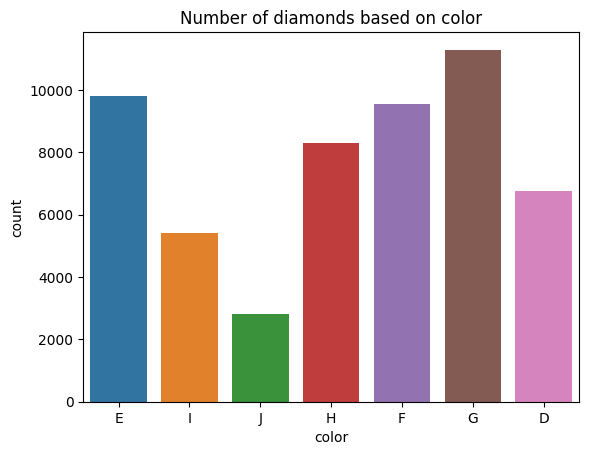

In [13]:
display(pd.DataFrame(df['clarity'].value_counts()))

sns.countplot(x = df['color'])
plt.title('Number of diamonds based on color')
plt.show()

The diamonds' colors are ranked from D (best) to J (Worst). The dataset have the highest number of diamonds that are ranked G. 

price
color cut             
D     Fair         163
      Good         662
      Ideal       2834
      Premium     1603
      Very Good   1513
E     Fair         224
      Good         933
      Ideal       3903
      Premium     2337
      Very Good   2400
F     Fair         312
      Good         909
      Ideal       3826
      Premium     2331
      Very Good   2164
G     Fair         314
      Good         871
      Ideal       4884
      Premium     2924
      Very Good   2299
H     Fair         303
      Good         702
      Ideal       3115
      Premium     2360
      Very Good   1824
I     Fair         175
      Good         522
      Ideal       2093
      Premium     1428
      Very Good   1204
J     Fair         119
      Good         307
      Ideal        896
      Premium      808
      Very Good    678

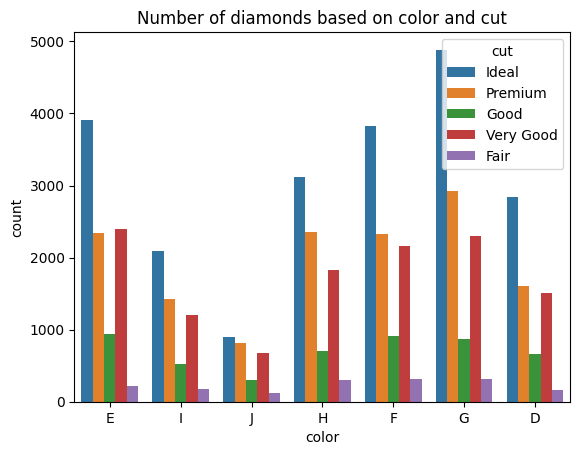

In [14]:
display(pd.DataFrame(df.groupby(['color', 'cut'])['price'].count()))

sns.countplot(x = df['color'], hue = df['cut'])
plt.title('Number of diamonds based on color and cut')
plt.show()

From the visualization above, there seems to be a relationship between color and cut variable which might've played a role in diamonds with fair cut having the highest average price as I shown earlier. This is because diamonds with fair cut are higher in higher rank compared to lower rank.

price
color cut                   
D     Fair       4291.061350
      Good       3405.382175
      Ideal      2629.094566
      Premium    3631.292576
      Very Good  3470.467284
E     Fair       3682.312500
      Good       3423.644159
      Ideal      2597.550090
      Premium    3538.914420
      Very Good  3214.652083
F     Fair       3827.003205
      Good       3495.750275
      Ideal      3374.939362
      Premium    4324.890176
      Very Good  3778.820240
G     Fair       4239.254777
      Good       4123.482204
      Ideal      3720.706388
      Premium    4500.742134
      Very Good  3872.753806
H     Fair       5135.683168
      Good       4276.254986
      Ideal      3889.334831
      Premium    5216.706780
      Very Good  4535.390351
I     Fair       4685.445714
      Good       5078.532567
      Ideal      4451.970377
      Premium    5946.180672
      Very Good  5255.879568
J     Fair       4975.655462
      Good       4574.172638
      Ideal      4918.186384
      Premium    6294.591584
      Very Good  5103.513274

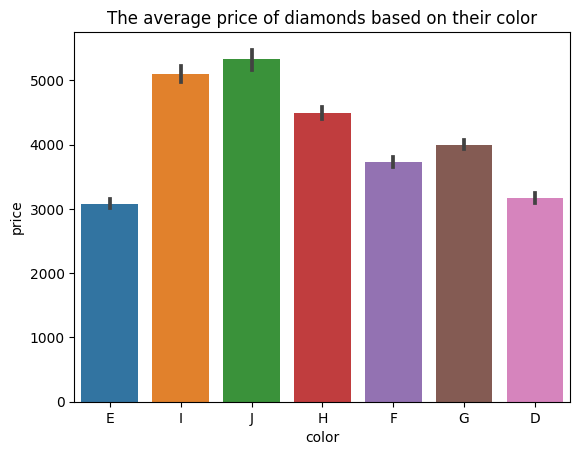

In [15]:
display(pd.DataFrame(df.groupby(['color', 'cut'])['price'].mean()))

sns.barplot(x = df['color'], y = df['price'])
plt.title('The average price of diamonds based on their color')
plt.show()

On average, J costs more than the rest which is also unexpected. However, a closer look look at the table further suggests there is a relationship between the two variables, cut and color.

To test if there's an interaction effect between the two variables I conducted a Two-Anova test

In [16]:
model = ols('price ~ color + cut + color:cut', data = df).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)
print(anova_table)

                 sum_sq       df           F         PR(>F)
color      2.550704e+10      6.0  279.370558   0.000000e+00
cut        9.699679e+09      4.0  159.356253  7.880786e-136
color:cut  1.653455e+09     24.0    4.527442   1.000780e-12
Residual   8.202709e+11  53905.0         NaN            NaN


From the Anova table, a 5% significance value, there is a statistically significant interaction between the two variables; cut and color

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

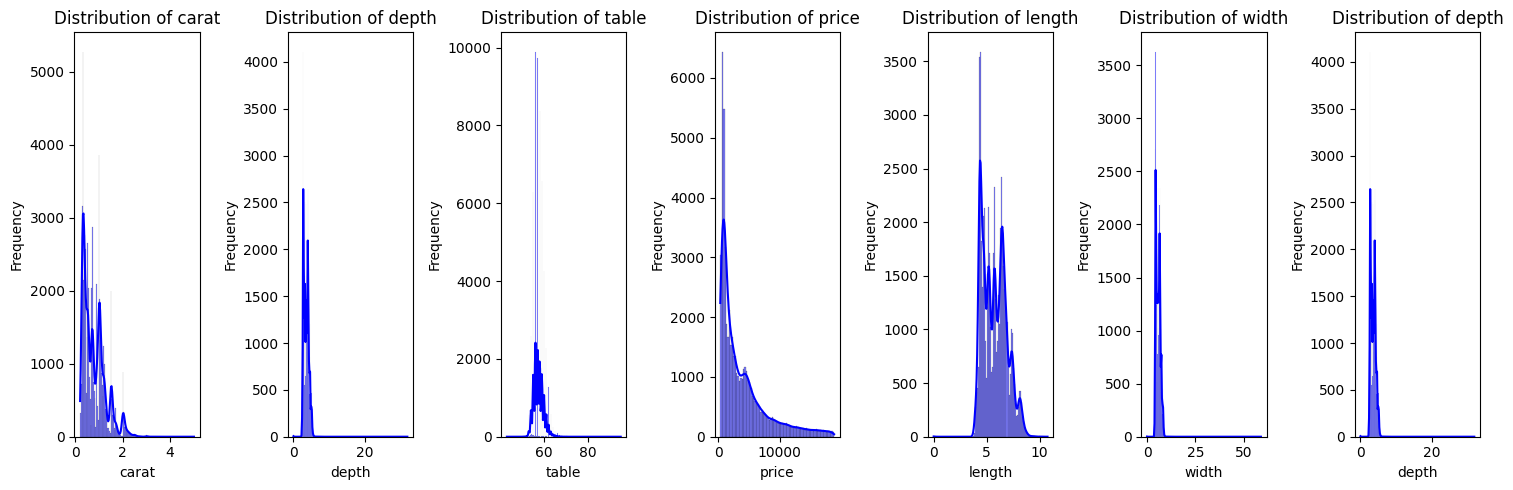

In [17]:
# Visualizing the distribution of the continuous features 
continuous_features = ['carat', 'depth', 'table', 'price', 'length', 'width', 'depth']

fig, axes = plt.subplots(nrows = 1, ncols = len(continuous_features), figsize =(15, 5))

for i, var in enumerate(continuous_features):
    sns.histplot(df[var],color = 'blue', kde = True, ax = axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

#adjust layout 
plt.tight_layout()

plt.show()

The distribution of the continuous variables shows that most of the variables are skewed to the right apart from the variable 'length'

## Feature Selection

To select the important features for our model, we need to have find out the features that are strongly correlated to the target variable, price.

In [18]:
df['area'] = df['length'] * df['width']
df

,carat,cut,color,clarity,total_depth,table,price,length,width,depth,area
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,15.7210
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,14.9376
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,16.4835
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,17.7660
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,18.8790
...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50,33.1200
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61,32.7175
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56,32.1488
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,37.6380


In [19]:
# Checking the correlation between the features 
correlation_matrix = df[['carat', 'total_depth', 'table', 'price', 'length', 'width', 'depth', 'area']].corr()
correlation_matrix

,carat,total_depth,table,price,length,width,depth,area
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387,0.981676
total_depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924,-0.030916
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929,0.187498
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249,0.901152
length,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772,0.984662
width,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006,0.990856
depth,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000,0.958460
area,0.981676,-0.030916,0.187498,0.901152,0.984662,0.990856,0.958460,1.000000


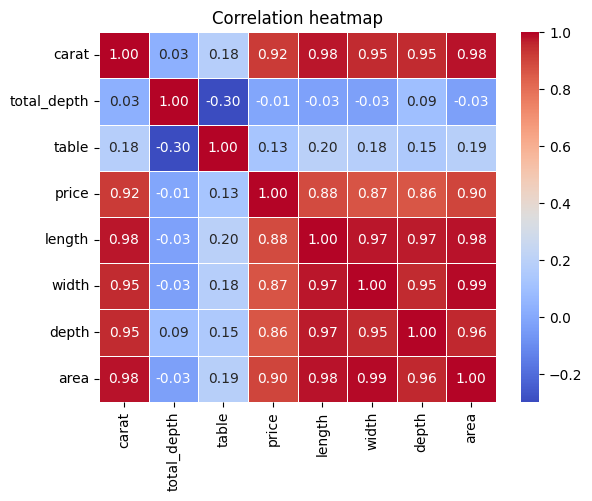

In [20]:
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidth = 0.5)
plt.title('Correlation heatmap')
plt.show()

From the heatmap and correlation matrix above; carat, length, width, area, and depth are strongly correlated with price i.e they have a linear relationship. 

## The Prediction Model

Since the target variable is a continuous variable, linear regression is the easy option 

In [21]:
Y = df['price'].to_numpy(dtype = float)
Y

array([ 326.,  326.,  327., ..., 2757., 2757., 2757.])

In [22]:
X = df[['carat','depth', 'color', 'cut', 'clarity', 'area', 'length', 'width']]
X = pd.get_dummies(X).to_numpy(dtype = float)
X

array([[ 0.23  ,  2.43  , 15.721 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.21  ,  2.31  , 14.9376, ...,  0.    ,  0.    ,  0.    ],
       [ 0.23  ,  2.31  , 16.4835, ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 0.7   ,  3.56  , 32.1488, ...,  0.    ,  0.    ,  0.    ],
       [ 0.86  ,  3.74  , 37.638 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.75  ,  3.64  , 34.2221, ...,  0.    ,  0.    ,  0.    ]])

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
#instantiate the model
lr = LinearRegression()

lr = lr.fit(X_train, Y_train)
print('Trainning accuracy:', r2_score(Y_train, lr.predict(X_train)))

Trainning accuracy: 0.9203151606826854


## Model Evaluation

In [25]:
y_pred = lr.predict(X_test)
print('Coefficient of determination :', r2_score(Y_test, y_pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(Y_test, y_pred)))

Coefficient of determination : 0.9236107794917834
Root mean squared error: 1082.4955177467696


The model was able to explain 92% of variabilty in the target variable. The model did not just perform well on the train dataset but it also performed well on test data.

## Ridge Regression

To see if building a more complex model can model the relationship between the variables better, I built a Ridge regression model.

In [26]:
ridge = Ridge()
parameters = {'alpha': [0.01, 0.1, 1.0, 10.0]}
grid_search = GridSearchCV(estimator = ridge, param_grid = parameters, cv = 5)
grid_search.fit(X_train, Y_train)
print('The best Alpha value:', grid_search.best_params_)

The best Alpha value: {'alpha': 10.0}


In [27]:
ridge = Ridge(alpha = 10)
ridge.fit(X_train, Y_train)
print('Coefficient of determination :', r2_score(Y_test, ridge.predict(X_test)))
print('Root mean squared error:', np.sqrt(mean_squared_error(Y_test, ridge.predict(X_test))))

Coefficient of determination : 0.9234338226812118
Root mean squared error: 1083.7486012728675


Even after regularization, there was no significant improvement in the performance of the model. 